### Import necessary libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import Ridge, LinearRegression 
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import SelectKBest, f_classif
import scipy.stats as stats
import xgboost as xgb
from xgboost import plot_importance

### Uploading data

In [33]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Viewing data

In [34]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [37]:
train_df.shape[0]

891

### Data visualization

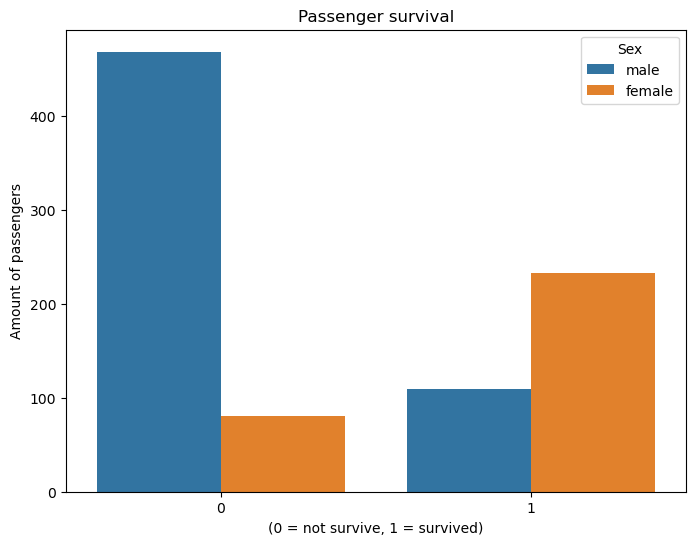

In [38]:
plt.figure(figsize=(8,6))
sns.countplot(x='Survived', data=train_df, hue='Sex')
plt.title('Passenger survival')
plt.xlabel('(0 = not survive, 1 = survived)')
plt.ylabel('Amount of passengers')
plt.show()

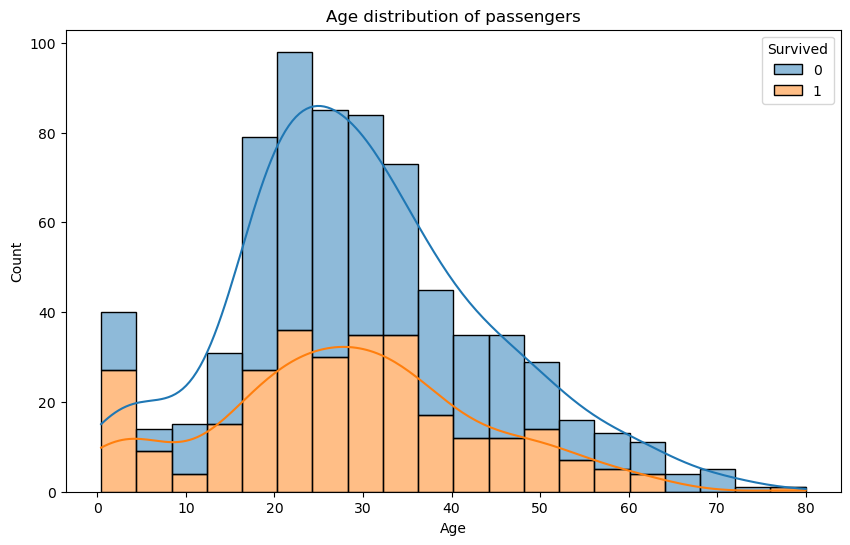

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Age', hue='Survived', kde=True, multiple="stack")
plt.title('Age distribution of passengers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

<Figure size 1000x600 with 0 Axes>

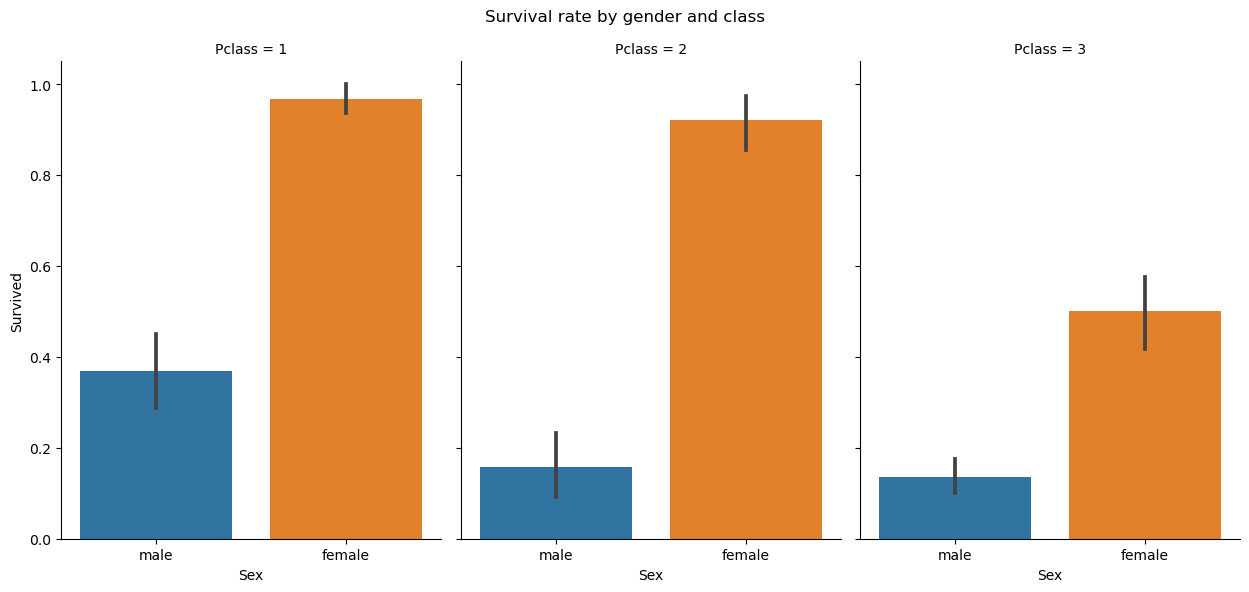

In [40]:
plt.figure(figsize=(10, 6))
sns.catplot(data=train_df, x='Sex', y='Survived', col='Pclass', kind='bar', height=6, aspect=.7)
plt.suptitle('Survival rate by gender and class')
plt.tight_layout()
plt.show()

### Creating functions

In [41]:
#view the percentage of missing values
def percent_missing(df):
    total = 100 *df.isnull().sum() / len(df)
    total = total[total > 0].sort_values(ascending=False)
    return total

In [42]:
# handling missing values and using scanning
def preprocess(df):
    for column in df.select_dtypes(exclude='number').columns:
        df[column] = df[column].fillna('None')
    
    for column in df.select_dtypes(include='number').columns:
        df[column] = df[column].fillna(0)
    
    scaler = StandardScaler()
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    
    return df

In [43]:
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [44]:
#Creating new featured
def custom_features(df):
    df['Title'] = df['Name'].apply(extract_title)
    df['family_size'] = df['SibSp'] + df['Parch']
    df['is_alone'] = (df['SibSp'] + df['Parch'] == 0).astype(int)
    return df

In [45]:
#OneHotEnconding
def encode(df):
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    categorical_columns = list(df.select_dtypes(exclude='number').columns)
    numeric_columns = list(df.select_dtypes(include='number').columns)
    transformed_values = encoder.fit_transform(df[categorical_columns])
    transformed_columns = list(encoder.get_feature_names_out())
    df[transformed_columns] = transformed_values
    
    return df[transformed_columns + numeric_columns]

### Processing of missing values

In [46]:
percent_missing(train_df)

Cabin       77.104377
Age         19.865320
Embarked     0.224467
dtype: float64

In [47]:
y = train_df['Survived']

In [48]:
train_df = train_df.drop('Survived', axis=1)

In [49]:
full_df = pd.concat([train_df, test_df], axis=0)

In [50]:
full_df = preprocess(full_df)

In [51]:
percent_missing(full_df)

Series([], dtype: float64)

### Creating new features

In [52]:
full_df = custom_features(full_df)

In [53]:
full_df['cabin_deck'] = full_df['Cabin'].str[0]

In [54]:
tra_df = full_df[['Name','Ticket','Cabin', 'PassengerId']]

In [55]:
full_df = full_df.drop(['Name', 'Ticket','Cabin','PassengerId'], axis=1)

### OneHotEnconding

In [56]:
full_df = encode(full_df)

In [57]:
full_df

,Sex_male,Embarked_None,Embarked_Q,Embarked_S,Title_Col,Title_Countess,Title_Don,Title_Dona,Title_Dr,Title_Jonkheer,...,cabin_deck_G,cabin_deck_N,cabin_deck_T,Pclass,Age,SibSp,Parch,Fare,family_size,is_alone
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.841916,-0.106773,0.481288,-0.445000,-0.503023,0.036288,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.546098,0.803138,0.481288,-0.445000,0.734878,0.036288,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.841916,0.120704,-0.479087,-0.445000,-0.489974,-0.924086,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.546098,0.632530,0.481288,-0.445000,0.383356,0.036288,0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.841916,0.632530,-0.479087,-0.445000,-0.487558,-0.924086,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.841916,-1.357902,-0.479087,-0.445000,-0.487558,-0.924086,0
414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-1.546098,0.860008,-0.479087,-0.445000,1.462090,-0.924086,0
415,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.841916,0.831573,-0.479087,-0.445000,-0.503023,-0.924086,0
416,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.841916,-1.357902,-0.479087,-0.445000,-0.487558,-0.924086,0


### Disconnecting the finished data

In [58]:
train_df = full_df[:len(train_df)]
test_df = full_df[len(train_df):]

In [59]:
train_df

,Sex_male,Embarked_None,Embarked_Q,Embarked_S,Title_Col,Title_Countess,Title_Don,Title_Dona,Title_Dr,Title_Jonkheer,...,cabin_deck_G,cabin_deck_N,cabin_deck_T,Pclass,Age,SibSp,Parch,Fare,family_size,is_alone
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.841916,-0.106773,0.481288,-0.445000,-0.503023,0.036288,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.546098,0.803138,0.481288,-0.445000,0.734878,0.036288,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.841916,0.120704,-0.479087,-0.445000,-0.489974,-0.924086,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.546098,0.632530,0.481288,-0.445000,0.383356,0.036288,0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.841916,0.632530,-0.479087,-0.445000,-0.487558,-0.924086,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.352091,0.177574,-0.479087,-0.445000,-0.391864,-0.924086,0
887,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.546098,-0.277382,-0.479087,-0.445000,-0.063217,-0.924086,0
888,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.841916,-1.357902,0.481288,1.866526,-0.189843,2.347813,0
889,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.546098,0.120704,-0.479087,-0.445000,-0.063217,-0.924086,0


### Model creation and training

In [60]:
#the values were matched via gridsearchcv
xgb = xgb.XGBClassifier( 
    colsample_bytree=0.1, 
    gamma=0.2, 
    learning_rate=0.01, 
    max_depth=2, 
    n_estimators=2500, 
    reg_alpha=0.2, 
    reg_lambda=0.2, 
    subsample=0.1
)

In [61]:
X = train_df

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [63]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [64]:
y_pred = xgb.predict(X_test)

### Evaluation of the model

In [65]:
accuracy = accuracy_score(y_pred, y_test)
print('Model accuracy after feature selection:', accuracy)

Model accuracy after feature selection: 0.7873134328358209


In [66]:
claf = classification_report(y_pred, y_test)

In [67]:
print(claf)

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       178
           1       0.64      0.82      0.72        90

    accuracy                           0.79       268
   macro avg       0.77      0.80      0.77       268
weighted avg       0.81      0.79      0.79       268



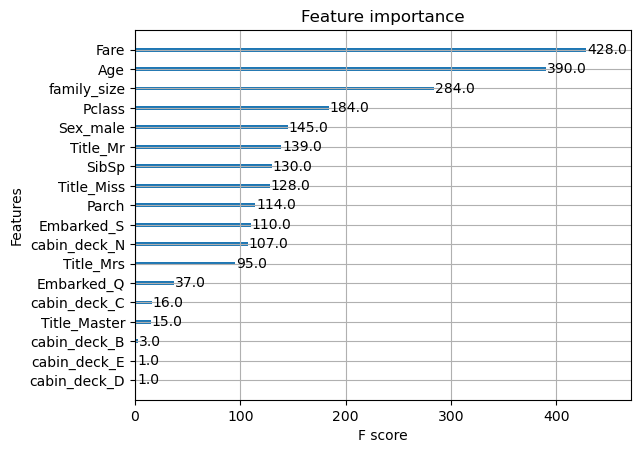

In [68]:
plot_importance(xgb)
plt.show()

### Saving the results

In [69]:
df_pred = xgb.predict(test_df)

In [70]:
submission_df = pd.DataFrame({
    'PassengerId': test_df.index + 892, 
    'Survived': df_pred
})


In [71]:
submission_df.to_csv('submission.csv', index=False)

## **Score:** 0.78708 in kaggle 